<a href="https://colab.research.google.com/github/ag826/AIPI590_XAI_F25/blob/main/AIPI509_XAI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590_XAI_F25"  # Change to your repo name
git_path = 'https://github.com/ag826/AIPI590_XAI_F25.git'  # Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"  # Add if using requirements.txt

# Create a subfolder for the notebook
subfolder_name = 'Assignment-Interpretable-ML'
subfolder_path = os.path.join(repo_name, subfolder_name)
!mkdir -p "{subfolder_path}"

# Change working directory to the new subfolder
path_to_notebook = subfolder_path
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'AIPI590_XAI_F25'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 1), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 511.14 KiB | 3.28 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML
AIPI509_XAI_.ipynb


In [140]:
pip install pygam

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from pygam import LogisticGAM, s, f
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [142]:
df=pd.read_csv("/content/AIPI590_XAI_F25/Assignment-Interpretable-ML/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# QUESTION 1

## The following code is to get a deeper understanding of the data available.

In [143]:
print("#####################################################")
print("--- Initial Data Info ---")
print("#####################################################")
print("")
df.info()
print("")
print("#####################################################")
print("--- First 5 Rows of Data ---")
print("#####################################################")
print("")
print(df.head())
print("")
print("#####################################################")
print("--- Null values of each column ---")
print("#####################################################")
print("")
print(df.isnull().sum())
print("")
print("#####################################################")
print("--- Data types of each column ---")
print("#####################################################")
print("")
print(df.dtypes)


#####################################################
--- Initial Data Info ---
#####################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  S

In [144]:
numeric_features = df.select_dtypes(include=["number"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

for col in ["customerID", "Churn", "TotalCharges"]:
    if col in categorical_features:
        categorical_features.remove(col)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
numeric_features.append("TotalCharges")

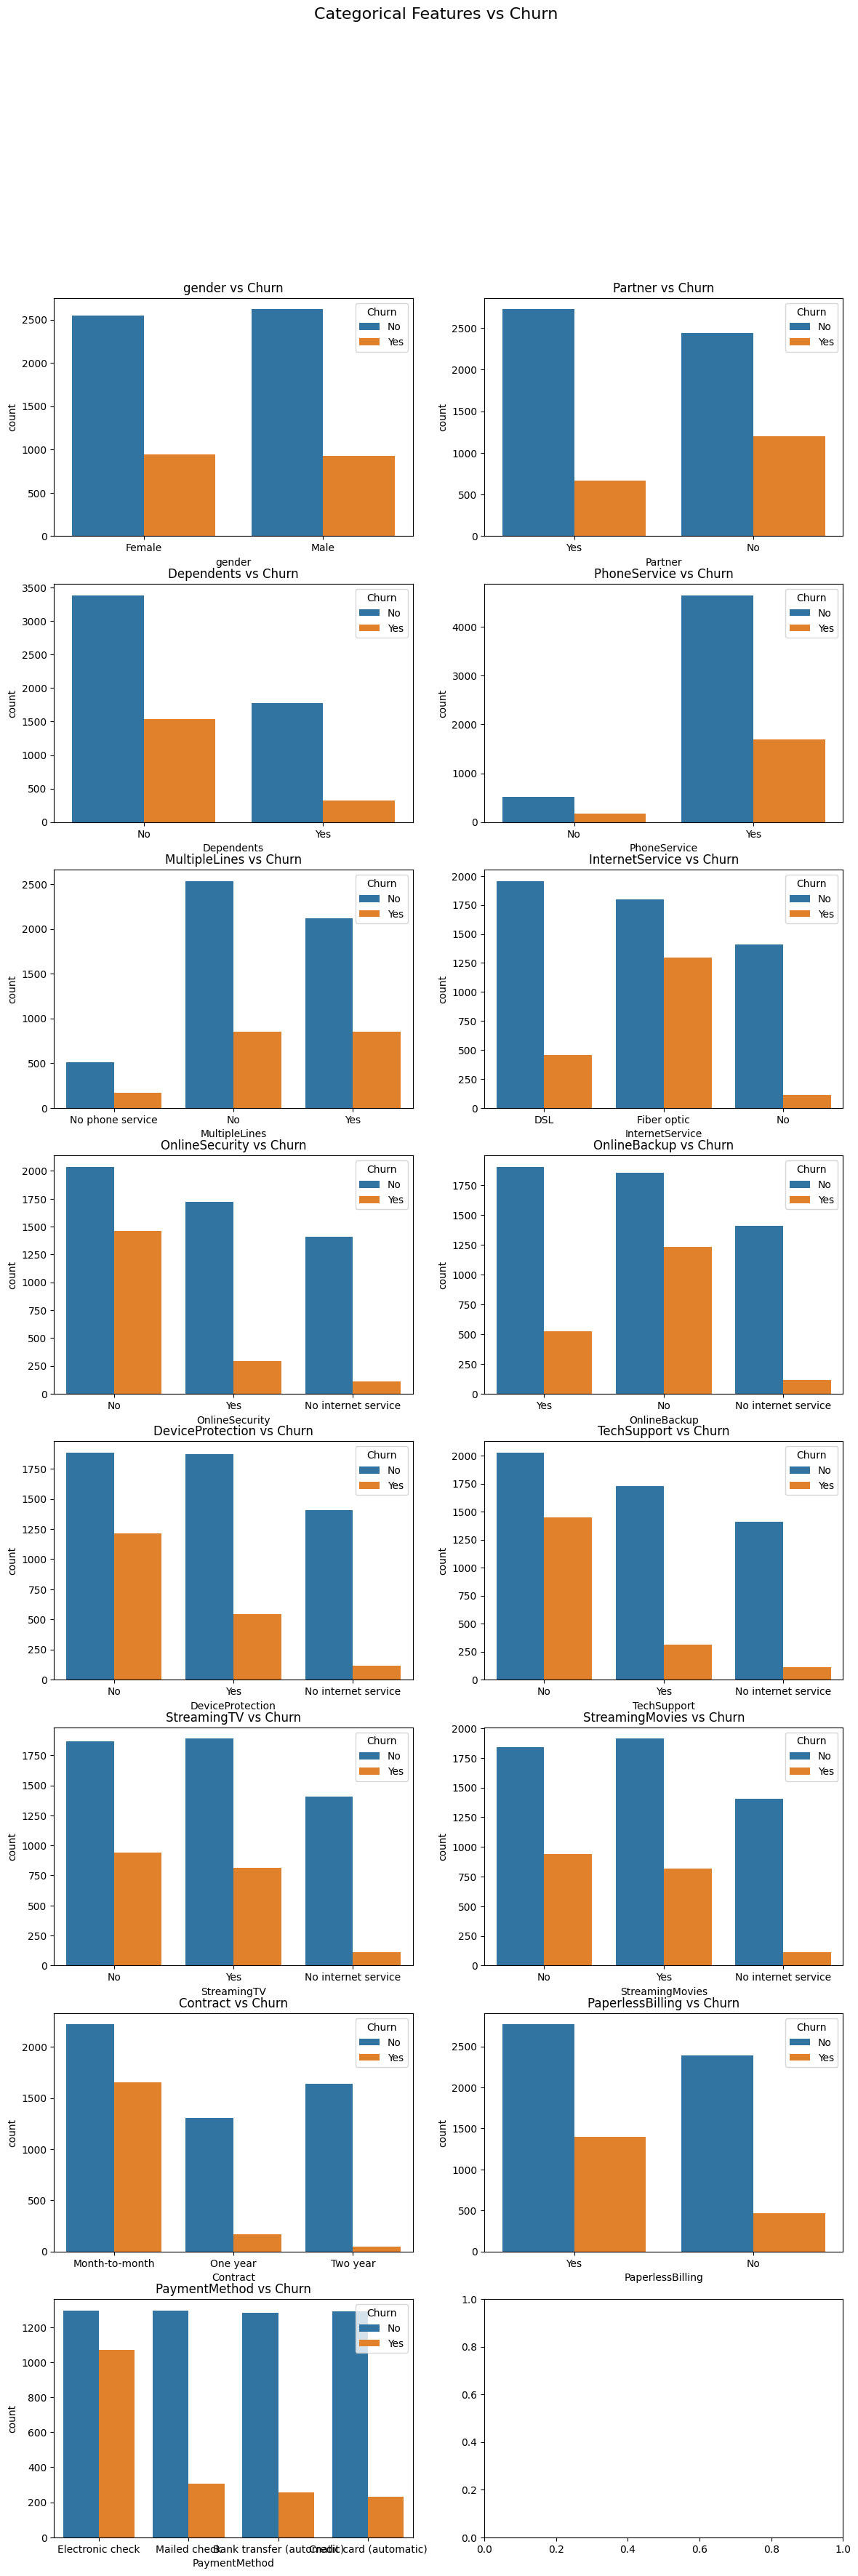

In [145]:
df["TotalCharges"].isnull().sum()
df.dropna(inplace=True)

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(14, 40))
fig.suptitle("Categorical Features vs Churn", fontsize=16)

for i, feature in enumerate(categorical_features):
    row, col = divmod(i, 2)
    sns.countplot(x=feature, hue="Churn", data=df, ax=axes[row, col])
    axes[row, col].set_title(f"{feature} vs Churn")

In [146]:
categorical_features.append("Churn")
df_dummies = pd.get_dummies(df[categorical_features], drop_first=True).astype(int)

df_final = pd.concat([df[numeric_features], df_dummies], axis=1)

target = "Churn_Yes"
X_vars = df_final.drop(columns=[target])
y_var = df_final[target]

X_vars = sm.add_constant(X_vars)

vif_df = pd.DataFrame({
    "feature": X_vars.columns,
    "VIF": [variance_inflation_factor(X_vars.values, idx) for idx in range(X_vars.shape[1])]
})

linear_model = sm.OLS(y_var, X_vars).fit()

print(linear_model.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                            OLS Regression Results                            
Dep. Variable:              Churn_Yes   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     120.9
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        04:20:52   Log-Likelihood:                -3057.9
No. Observations:                7032   AIC:                             6164.
Df Residuals:                    7008   BIC:                             6328.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

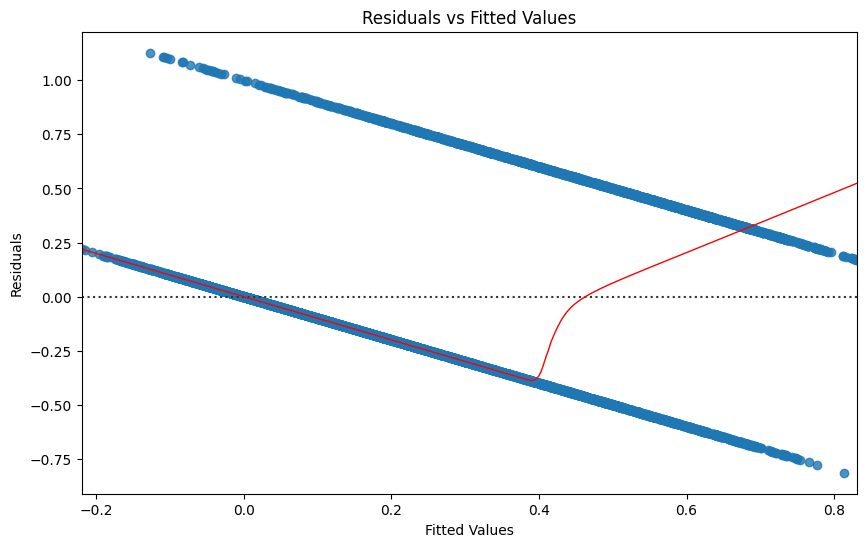

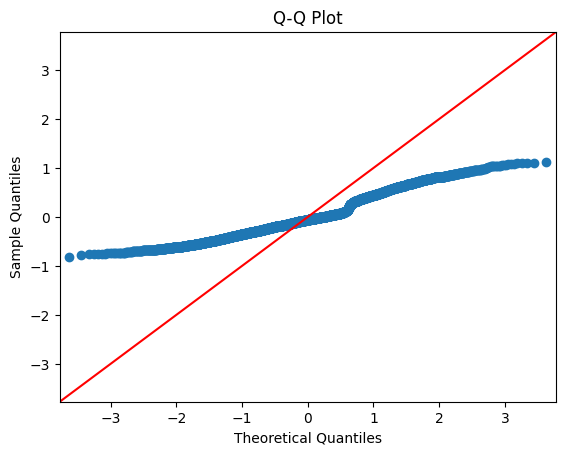

In [147]:

plt.figure(figsize=(10, 6))
sns.residplot(x=linear_model.fittedvalues, y=linear_model.resid, lowess=True,
              line_kws={"color": "red", "lw": 1})
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

sm.qqplot(linear_model.resid, line="45")
plt.title("Q-Q Plot")
plt.show()


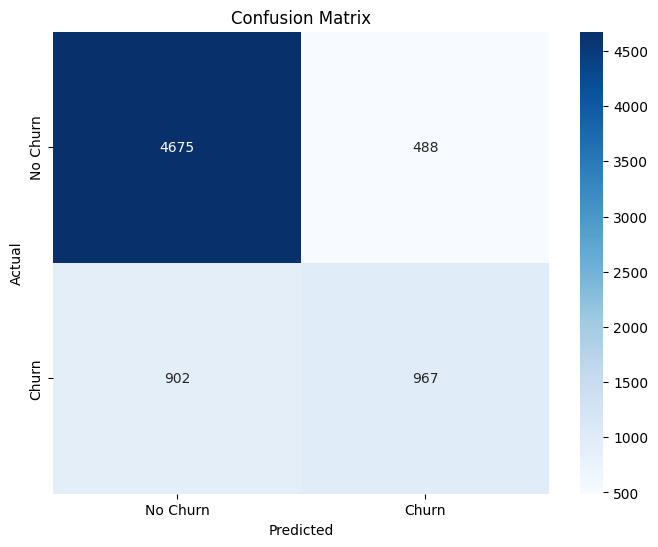

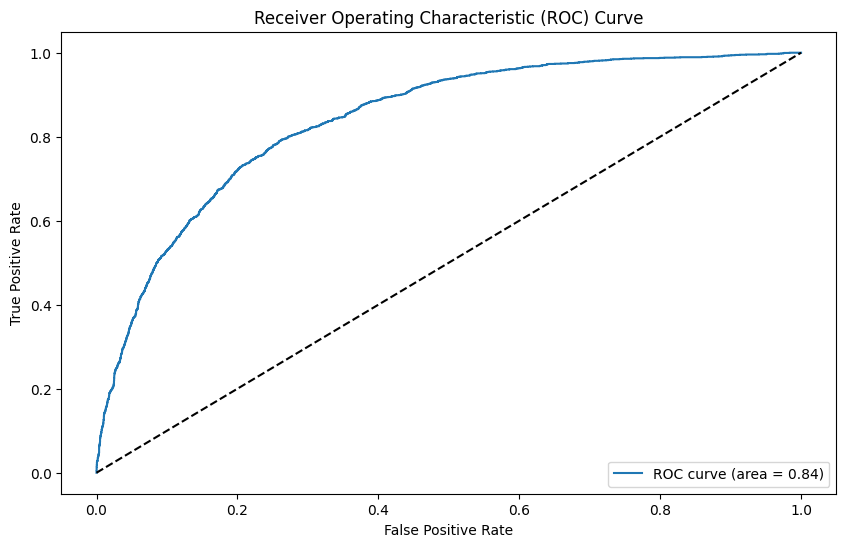

In [148]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

y_pred_continuous = linear_model.predict(X_vars)

y_pred_binary = y_pred_continuous > 0.5

conf_matrix = confusion_matrix(y_var, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_var, y_pred_continuous)
roc_auc = roc_auc_score(y_var, y_pred_continuous)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [150]:
vif_df = pd.DataFrame()
vif_df["feature"] = X_vars.columns
vif_df["VIF"] = [variance_inflation_factor(X_vars.values, i) for i in range(X_vars.shape[1])]

X_reduced = X_vars.copy()
for feat, vif_val in zip(vif_df["feature"], vif_df["VIF"]):
    if vif_val == np.inf:
        X_reduced.drop(columns=[feat], inplace=True)


logistic_model = sm.Logit(y_var, X_reduced).fit()
print(logistic_model.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Optimization terminated successfully.
         Current function value: 0.419697
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_Yes   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7010
Method:                           MLE   Df Model:                           21
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2752
Time:                        04:22:50   Log-Likelihood:                -2951.3
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.9994      

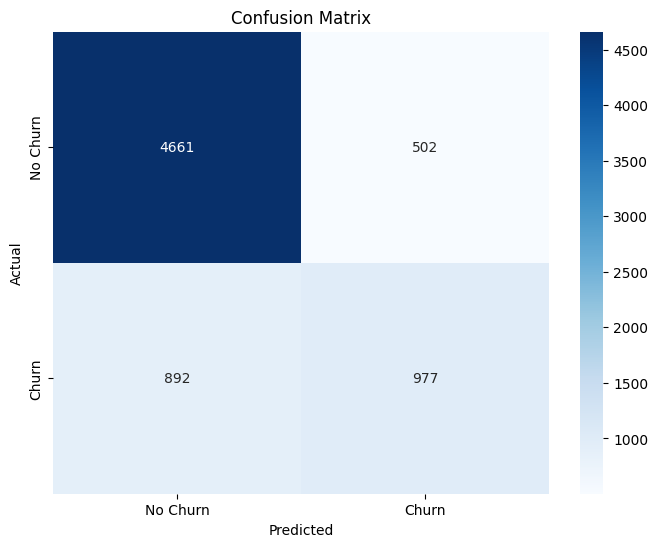

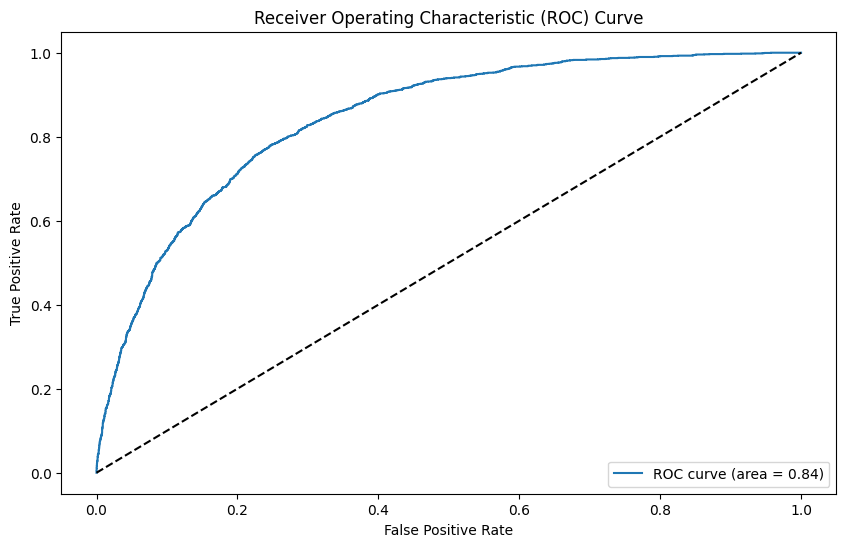

In [151]:
y_pred_binary = logistic_model.predict(X_reduced) > 0.5
conf_matrix = confusion_matrix(y_var, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_var, logistic_model.predict(X_reduced))
roc_auc = roc_auc_score(y_var, logistic_model.predict(X_reduced))
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [152]:
gam_model = LogisticGAM(
    s(1) + s(2) + s(3) + s(4)
    + f(5) + f(6) + f(7) + f(8)
    + f(9) + f(10) + f(11) + f(12)
    + f(13) + f(14) + f(15) + f(16)
    + f(17) + f(18) + f(19) + f(20)
    + f(21)
).fit(X_reduced, y_var)

gam_model.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     55.7351
Link Function:                        LogitLink Log Likelihood:                                 -2833.8201
Number of Samples:                         7032 AIC:                                             5779.1104
                                                AICc:                                            5780.0498
                                                UBRE:                                               2.8282
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.304
Feature Function                  Lam

/tmp/ipython-input-3094009575.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


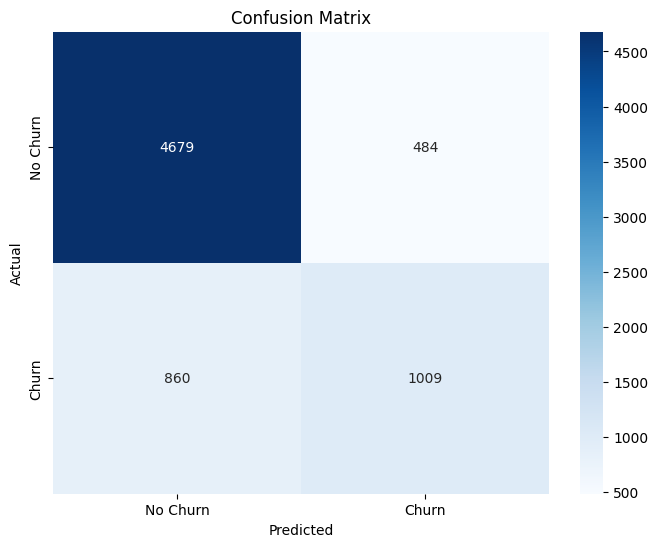

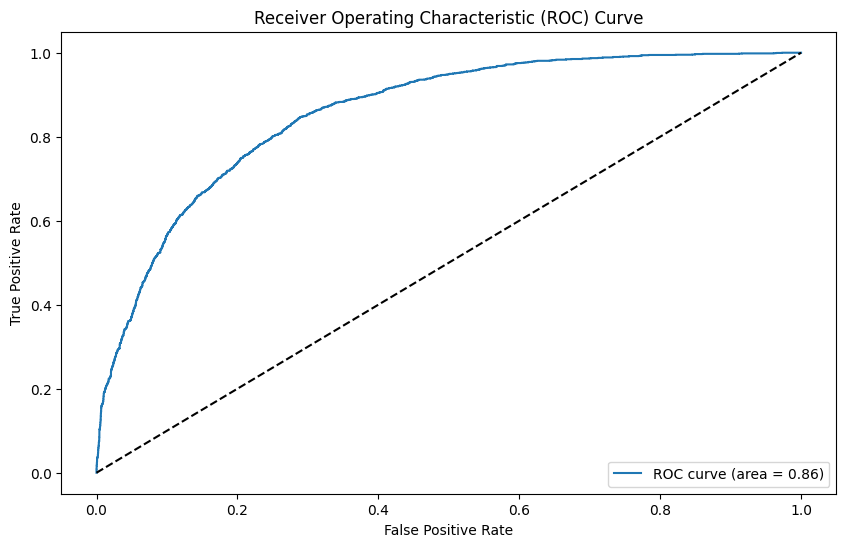

In [153]:
y_pred_prob = gam_model.predict_proba(X_reduced)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

conf_matrix = confusion_matrix(y_var, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_var, y_pred_prob)
roc_auc = roc_auc_score(y_var, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()